In [1]:
# scripts/train_and_convert.py
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100
DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\Data' # Path to your dataset

In [3]:
# 1. Load Data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Save labels
with open("model/labels.txt", "w") as f:
    for label in train_generator.class_indices:
        f.write(f"{label}\n")

Found 10664 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.


In [5]:
# 2. Build MobileNetV2 Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Track validation loss
    patience=5,                 # Wait for 5 epochs without improvement
    restore_best_weights=True,  # Roll back to the best model
    mode='min',                 # Minimize val_loss
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping]
)

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 323s 953ms/step - accuracy: 0.7126 - loss: 0.8783 - val_accuracy: 0.8523 - val_loss: 0.3611
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 329s 984ms/step - accuracy: 0.8767 - loss: 0.3115 - val_accuracy: 0.8613 - val_loss: 0.3294
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.8924 - loss: 0.2717 - val_accuracy: 0.8756 - val_loss: 0.3084
Epoch 4/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.9010 - loss: 0.2485 - val_accuracy: 0.8737 - val_loss: 0.3297
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - accuracy: 0.9094 - loss: 0.2294 - val_accuracy: 0.8748 - val_loss: 0.3227
Epoch 6/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - accuracy: 0.9090 - loss: 0.2193 - val_accuracy: 0.8662 - val_loss: 0.3901
Epoch 7/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.9131 - loss: 0.2086 - val_accuracy: 0.8812 - val_loss: 0.3327
Epoch 8/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.9156 - loss: 0.2069 - va

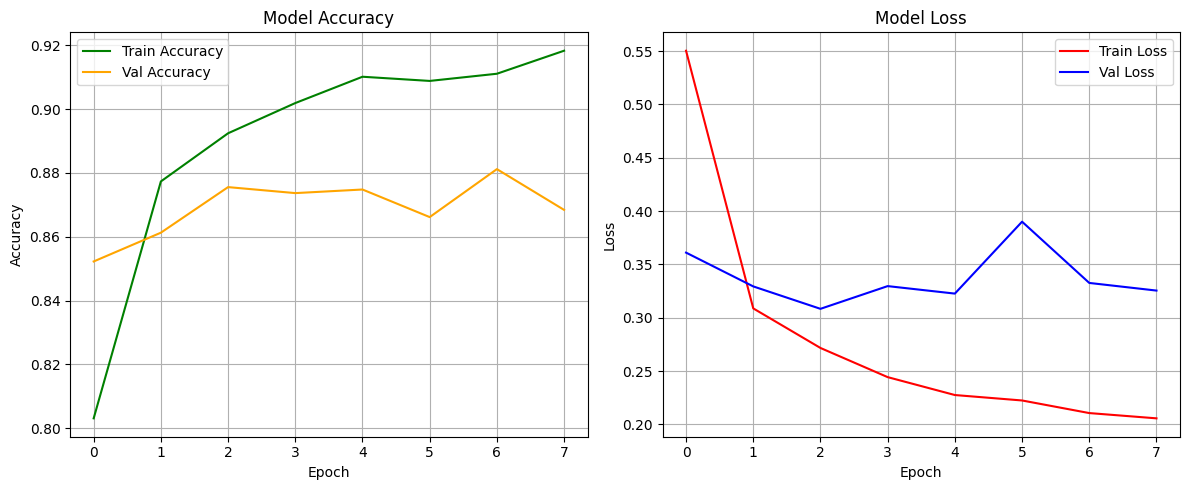

In [7]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# 4. Save Keras Model
model.save("model/mobilenetv2_model.h5")

# 5. Convert to TFLite (Optimized for Mobile)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save .tflite model
with open("model/mobilenetv2_quant.tflite", "wb") as f:
    f.write(tflite_model)

print("Model training and TFLite conversion complete!")

INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpn4rcukl5\assets


INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpn4rcukl5\assets


Saved artifact at 'C:\Users\piyus\AppData\Local\Temp\tmpn4rcukl5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  1760946665424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946667344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946666768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946667152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946666960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1762431537552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946663696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760955499728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946665808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760946665232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1760